<a href="https://colab.research.google.com/github/NinaMwangi/sound_clustering/blob/main/Sound_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [ ]:
import librosa
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Sound Data

In [ ]:
# Load the Data
unlabelled_data_path = '/content/drive/MyDrive/Sound Clustering/unlabelled_sounds'

# Feature Extraction

In [ ]:
def extract_mel_spectrogram(file_path, n_mels=128, n_fft=2048):
    y, sr = librosa.load(file_path, sr=None)

    # Padding short signals
    if len(y) < n_fft:
        y = np.pad(y, (0, n_fft - len(y)))

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return np.mean(mel_db, axis=1)

In [ ]:
# Processing the dataset
def load_features_from_directory(unlabelled_data_path):
    features = []
    filenames = []
    for file in tqdm(os.listdir(unlabelled_data_path)):
      if file.endswith('.wav'):
        path = os.path.join(unlabelled_data_path, file)
        mel_feat = extract_mel_spectrogram(path)
        features.append(mel_feat)
        filenames.append(file)
    return pd.DataFrame(features), filenames
    # Create DataFrame
    df = pd.DataFrame(features)
    df['filename'] = filenames

df, filenames = load_features_from_directory(unlabelled_data_path)
df['filename'] = filenames

df.head()

100%|██████████| 3000/3000 [02:10<00:00, 23.00it/s]


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,filename
0,-44.195824,-44.140255,-41.892666,-43.001312,-34.691563,-22.292297,-19.999441,-22.214630,-20.683287,-17.718996,...,-38.127251,-37.578438,-39.658535,-41.799438,-44.222172,-46.666756,-50.062798,-52.495251,-52.539776,368.wav
1,-62.144218,-57.955036,-46.071625,-33.686493,-12.011313,-15.355673,-31.280535,-24.411104,-20.629227,-12.088065,...,-48.925499,-48.814693,-49.693443,-50.021412,-51.640347,-49.520111,-48.667873,-50.953003,-52.579700,2415.wav
2,-63.380470,-63.449245,-51.297192,-35.566319,-31.948198,-35.746571,-35.805042,-35.208363,-31.493469,-33.287170,...,-62.567688,-64.169037,-64.403206,-63.833908,-63.227779,-62.664120,-61.981327,-61.659180,-60.566227,33.wav
3,-29.052111,-45.389828,-45.551586,-47.746861,-46.262371,-42.964199,-29.839392,-23.723312,-26.073309,-28.842764,...,-38.085625,-38.033501,-36.763847,-39.367218,-39.462261,-39.810207,-40.801563,-40.432484,-40.435940,1902.wav
4,-51.814869,-49.213531,-48.122349,-50.173412,-40.198235,-18.064917,-16.048098,-31.438309,-40.473164,-40.889408,...,-49.706272,-52.732571,-52.405025,-52.447571,-52.409317,-53.946136,-56.929447,-58.061985,-58.829700,1788.wav


# Visualisation prior to Dimension Reduction

## Scatter Plot

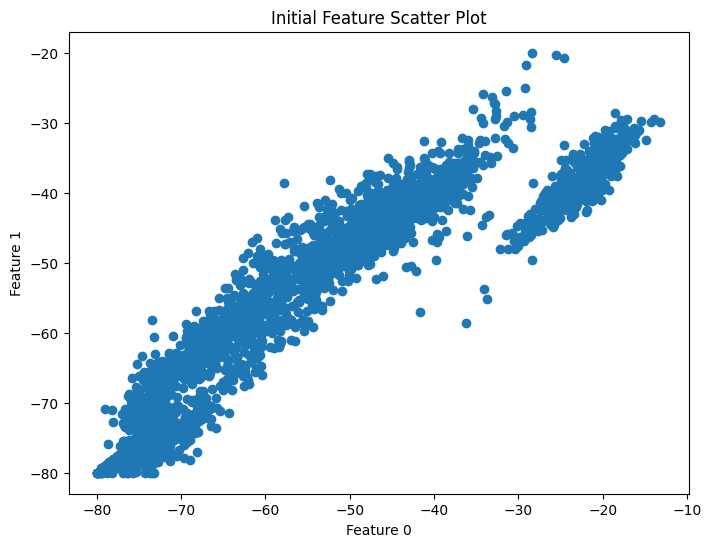

In [ ]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(df[0], df[1])
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Initial Feature Scatter Plot')
plt.show()


## Pair Plot

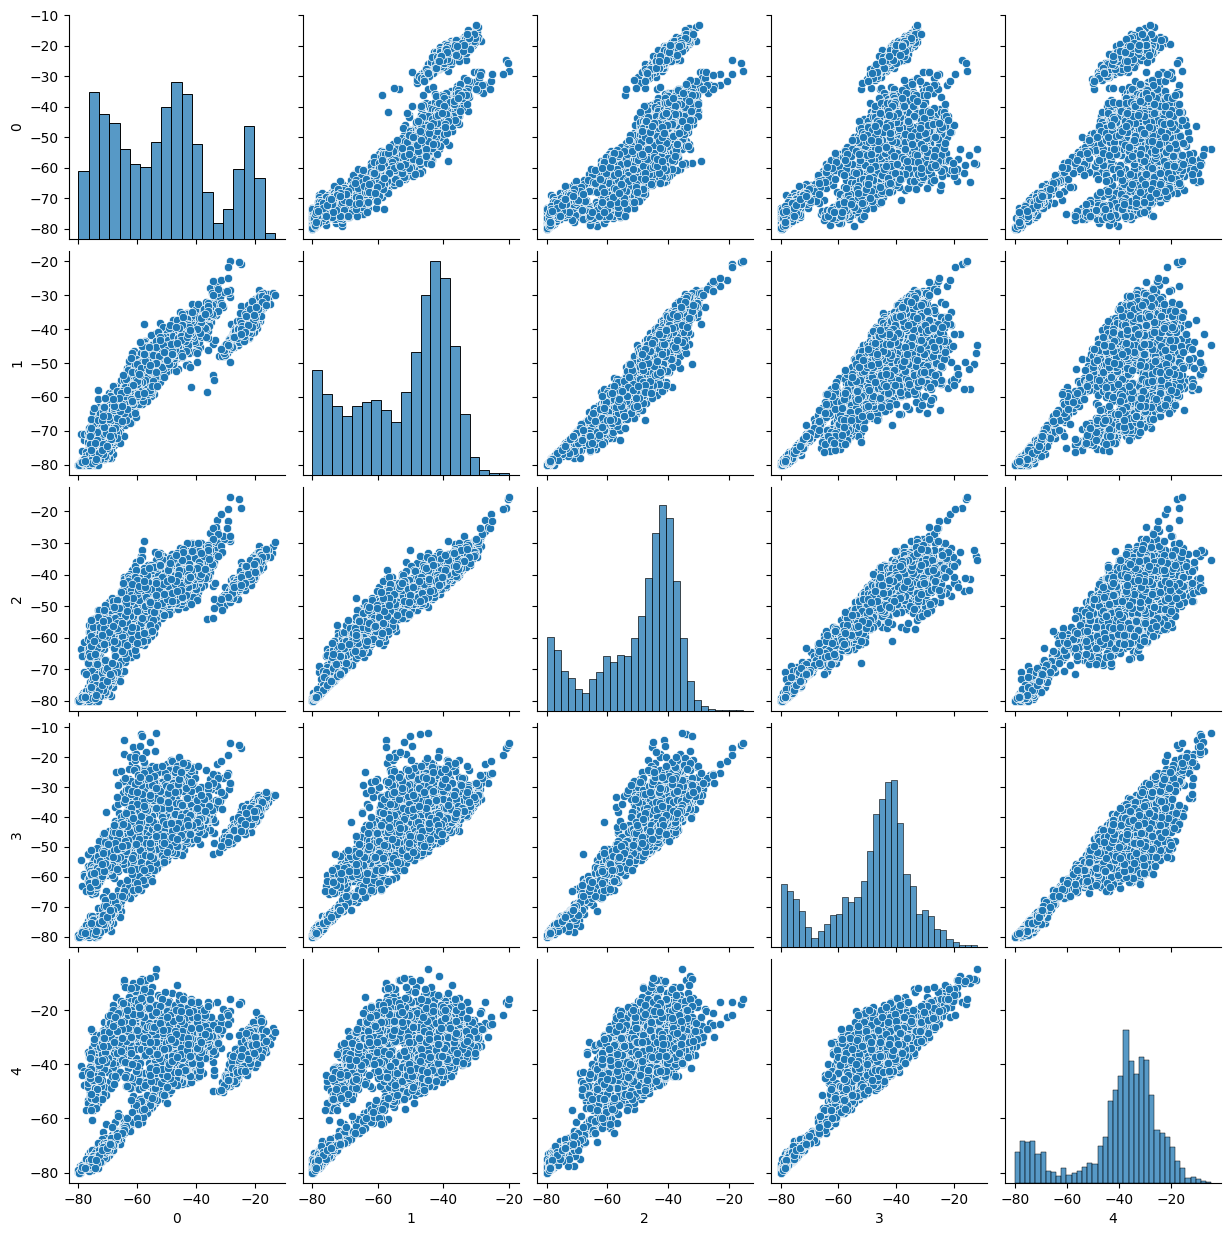

In [ ]:
sns.pairplot(df.iloc[:, :5])

### Why is dimensionality reduction important.
- The MEL spectogram spans over 128 features, this already in itself is a challenge when it comes to plotting the features using a scatter plot or even a pairplot.
- Visualising 2D plots is limited because I cant visualise all the features in a single plot. With the scatter plot I can only visualise a max of 3 features meaning I would be forced to ignore the rest of the features same as the pairplot which can only visailise a few features at a time or else it becomes crowded and very cluttered.
- Therefore in this case it is difficult to derive any meaningful insights as I am not able to interpret any patterns on the full dataset due to the limitations caused by the high dimensionality of the data.
- *Conclusion* - The plots are not ideal for visualising and clustering this data.

# Dimensionality Reduction

## PCA

In [ ]:
# Dropping the filename column
new_df = df.drop(columns=['filename'])

# DR using PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(new_df)

# Extract and display the Explained Variance Ratio for all Principal Components
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for all Principal Components:")
print(explained_variance_ratio)

pca_result = pca_result[:, :3]

Explained Variance Ratio for all Principal Components:
[0.4542737  0.17724016 0.10482426 0.04314446 0.0329653  0.02580603
 0.01898351 0.01677915 0.01279225 0.00968887]


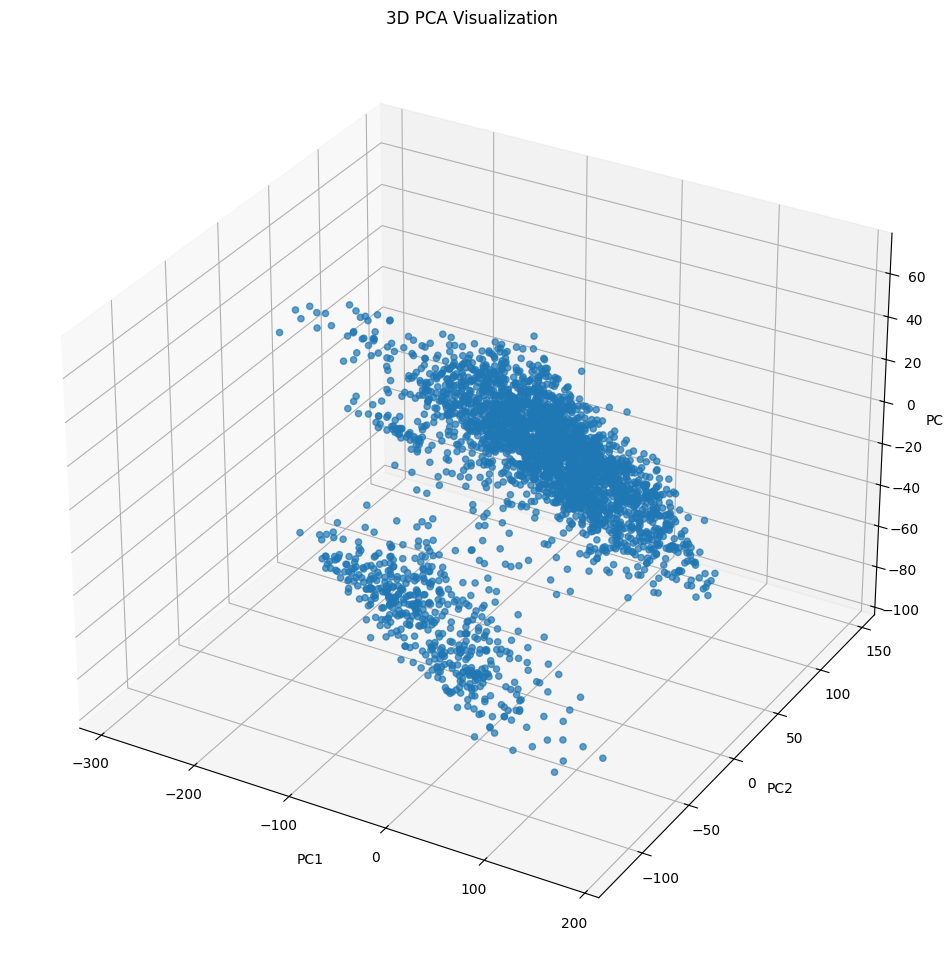

In [ ]:
# PCA 3D visualisation
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], alpha=0.7)
ax.set_title("3D PCA Visualization")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

## t-SNE

In [ ]:
# DR using t-SNE
tsne = TSNE(n_components=3, perplexity=50, random_state=42)
tsne_result = tsne.fit_transform(new_df)
print("KL Divergence:", tsne.kl_divergence_)

KL Divergence: 0.6365810036659241


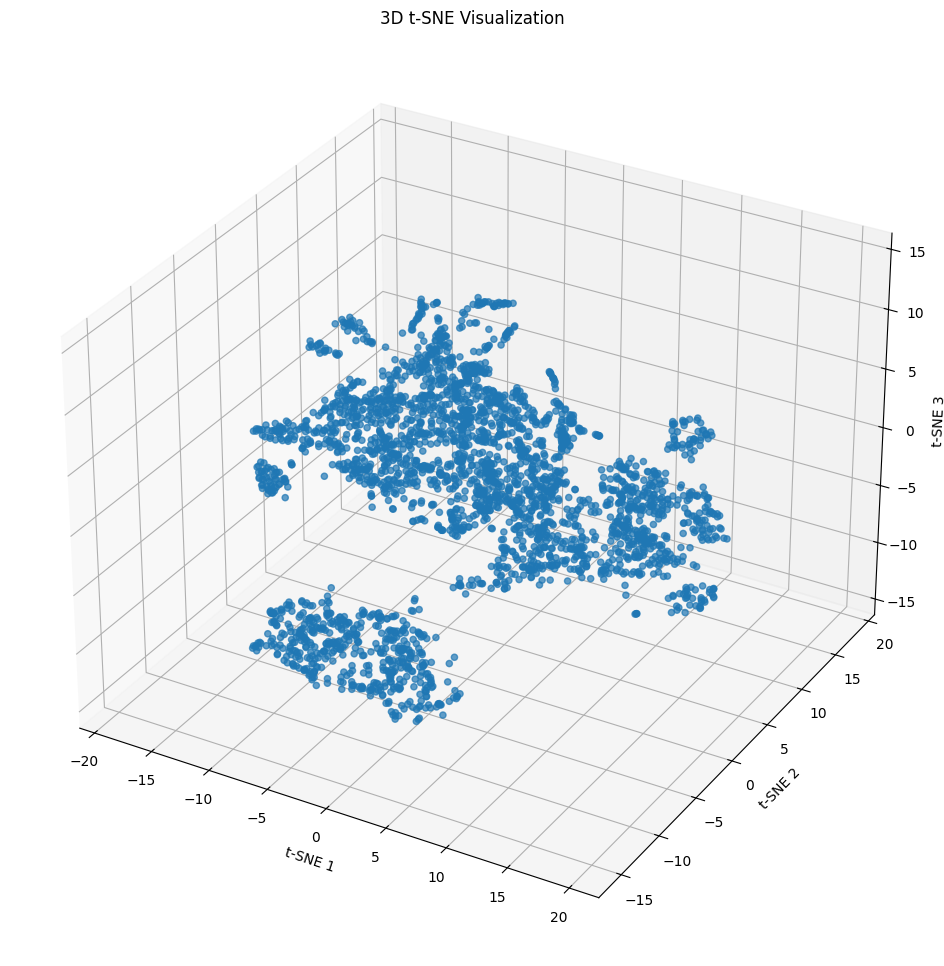

In [ ]:
# t-SNE 3D visualisation
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], alpha=0.7)
ax.set_title("3D t-SNE Visualization")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
Based on my visualisation I would say t-SNE provides better separability compared to PCA.
- From the PCA visualisation the data is separated into 2 clusters.
- The t-SNE visualisation has roughly around 10 clusters, meaning its separating the data better than the PCA.

# Clustering the sound Data
## K-Means Clustering with Elbow & Silhouette

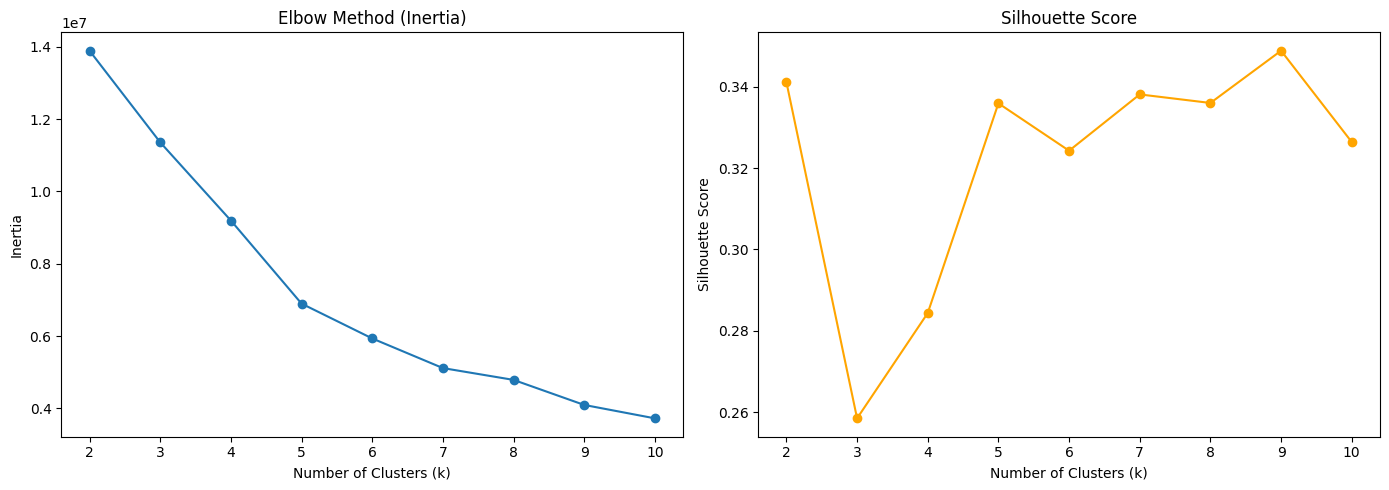

In [ ]:
# Optimize number of clusters using Elbow Method and Silhoette

# Trying different cluster sizes
inertias = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(pca_result, kmeans.labels_))

# Plot Elbow Method and Silhouette Score
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(k_values, inertias, marker='o')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')

ax[1].plot(k_values, sil_scores, marker='o', color='orange')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
# Final clustering for KMeans
k_optimal = 5
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
kmeans_labels = kmeans_final.fit_predict(pca_result)

## DBSCAN Clustering

In [ ]:
# Scale data for DBSCAN
X_scaled = StandardScaler().fit_transform(pca_result)

# Fit DBSCAN
dbscan = DBSCAN(eps=0.32, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)


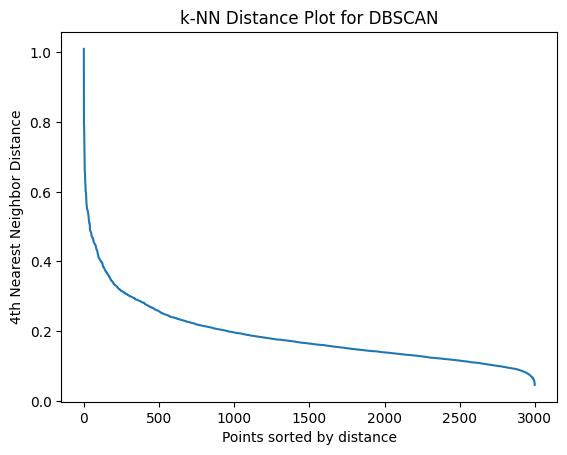

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot k-distance graph
distance_desc = sorted(distances[:, 3], reverse=True)
plt.plot(distance_desc)
plt.title("k-NN Distance Plot for DBSCAN")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()


In [ ]:
def plot_3d_clusters_side_by_side(X, labels1, labels2, title1="K-Means", title2="DBSCAN"):
    fig = plt.figure(figsize=(18, 7))

    # K-Means
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels1, cmap='tab10', alpha=0.8)
    ax1.set_title(title1)
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax1.set_zlabel('Component 3')
    fig.colorbar(scatter1, ax=ax1, shrink=0.6)

    # DBSCAN
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels2, cmap='tab10', alpha=0.8)
    ax2.set_title(title2)
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.set_zlabel('Component 3')
    fig.colorbar(scatter2, ax=ax2, shrink=0.6)

    plt.tight_layout()
    plt.show()

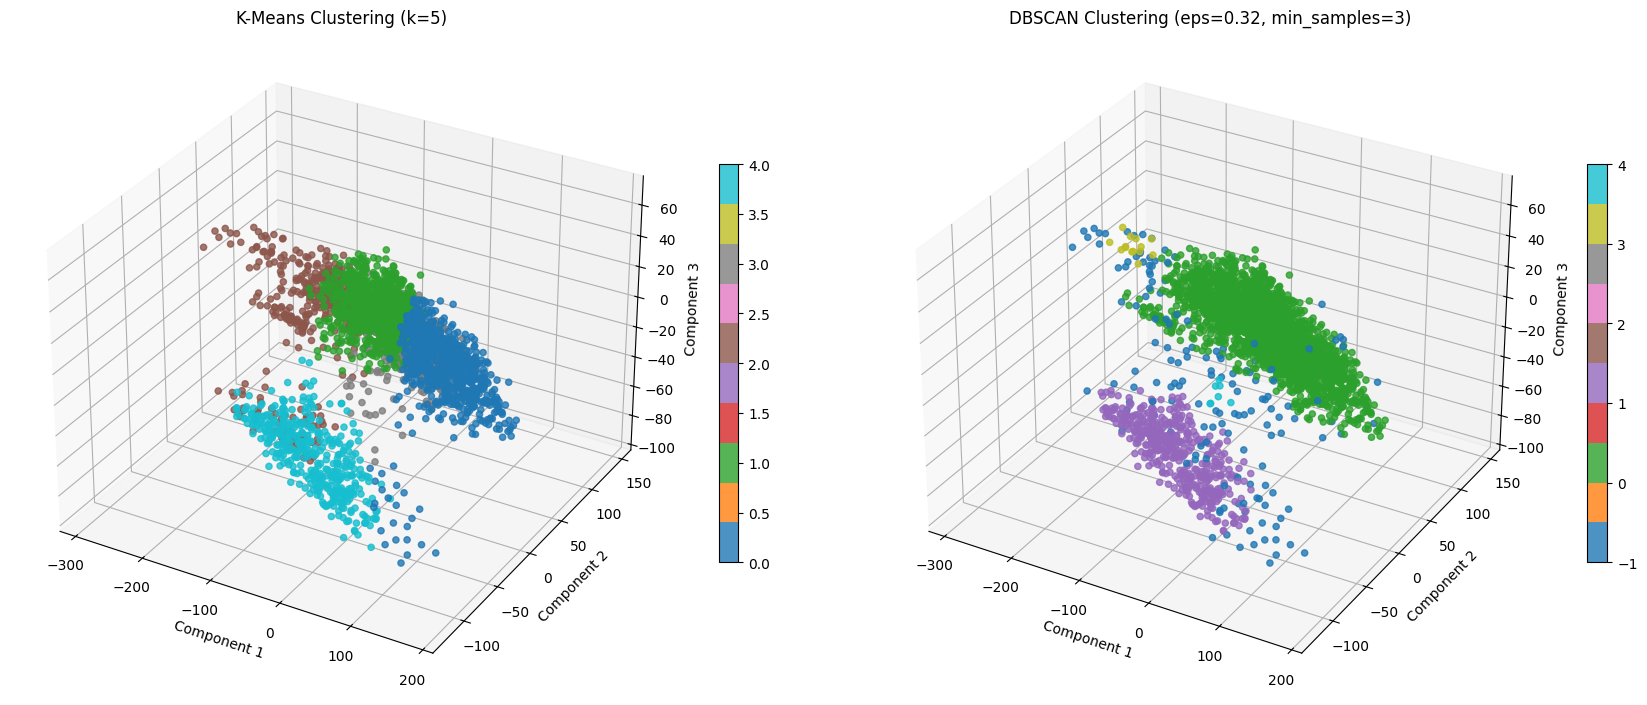

In [ ]:
plot_3d_clusters_side_by_side(pca_result, kmeans_labels, dbscan_labels,
                              title1="K-Means Clustering (k=5)",
                              title2="DBSCAN Clustering (eps=0.32, min_samples=3)")

# Evaluation

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate K-Means
kmeans_silhouette = silhouette_score(pca_result, kmeans_labels)
kmeans_db_index = davies_bouldin_score(pca_result, kmeans_labels)

# Evaluate DBSCAN (only if valid clusters exist)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(pca_result, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(pca_result, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

# Print evaluation results
print(f"K-Means (PCA space) - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN (PCA space) - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters (likely due to all points being noise or only one cluster).")



K-Means (PCA space) - Silhouette Score: 0.3359, Davies-Bouldin Index: 0.9215
DBSCAN (PCA space) - Silhouette Score: 0.0305, Davies-Bouldin Index: 4.0814


### Discuss the results (max 5 lines)
K-Means achieved a significantly better Silhouette Score (0.3359) and a lower Davies-Bouldin Index (0.9215), indicating more compact and well-separated clusters. DBSCAN struggled, producing a Silhouette Score of 0.0305 and a high DBI of 4.0814. This suggests DBSCAN was unable to form consistent dense clusters under the chosen eps. K-Means performed better for this structured PCA-reduced dataset. Its assumption of spherical clusters matched the dataset’s shape better than DBSCAN's density-based approach.

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
  - Dimensionality reduction was crucial in this assignment. With 128 Mel features, scatter and pair plots became unreadable and impossible to visualise all the features.
- Justify why certain clustering methods worked better.
  -  PCA helped capture maximum variance in just 3 components, enabling 3D plotting and better clustering performance. t-SNE, while computationally intensive, offered better visual separability but was less suitable for actual clustering due to its non-linearity.K-Means outperformed DBSCAN in both metrics and visual results, likely because DBSCAN couldn’t separate clusters well in PCA space.
- Relate findings to real-world clustering challenges.
  - In real-world scenarios, choosing the right clustering method depends on the data's structure and the presence of noise or varying densities.